In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [10]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
import cv2
from PIL import Image
from matplotlib import pyplot as plt, rcParams, animation


In [11]:
def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute


In [12]:
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))
    
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf

In [13]:
def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        #os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()
    
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model


In [14]:
# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

In [15]:
print(classes)

('airfield', 'airplane_cabin', 'airport_terminal', 'alcove', 'alley', 'amphitheater', 'amusement_arcade', 'amusement_park', 'apartment_building/outdoor', 'aquarium', 'aqueduct', 'arcade', 'arch', 'archaelogical_excavation', 'archive', 'arena/hockey', 'arena/performance', 'arena/rodeo', 'army_base', 'art_gallery', 'art_school', 'art_studio', 'artists_loft', 'assembly_line', 'athletic_field/outdoor', 'atrium/public', 'attic', 'auditorium', 'auto_factory', 'auto_showroom', 'badlands', 'bakery/shop', 'balcony/exterior', 'balcony/interior', 'ball_pit', 'ballroom', 'bamboo_forest', 'bank_vault', 'banquet_hall', 'bar', 'barn', 'barndoor', 'baseball_field', 'basement', 'basketball_court/indoor', 'bathroom', 'bazaar/indoor', 'bazaar/outdoor', 'beach', 'beach_house', 'beauty_salon', 'bedchamber', 'bedroom', 'beer_garden', 'beer_hall', 'berth', 'biology_laboratory', 'boardwalk', 'boat_deck', 'boathouse', 'bookstore', 'booth/indoor', 'botanical_garden', 'bow_window/indoor', 'bowling_alley', 'boxin

In [16]:
# labels_IO: 365 scene categories into just indoor and outdoor
# 0 is indoor (160 cates), 1 is outdoor (205 cates)
print(W_attribute)

[[-0.01290726 -0.00644846 -0.00202072 ... -0.00658392 -0.00812169
  -0.00935397]
 [-0.0082366  -0.00036615  0.0280863  ... -0.00408997 -0.00512203
  -0.01074815]
 [-0.00644194  0.00142965  0.02686856 ... -0.00673635 -0.00809473
  -0.00783996]
 ...
 [-0.000456   -0.00710083 -0.00287423 ... -0.00477239 -0.00693677
  -0.00975015]
 [ 0.00570639 -0.0029761   0.00421021 ...  0.00042821 -0.00839629
   0.01420205]
 [-0.00529901 -0.01164644 -0.00684551 ... -0.00529736 -0.01159335
  -0.01354748]]


In [18]:
# load the model
features_blobs = []

#model_file = 'wideresnet18_places365.pth.tar'
#import wideresnet
#model = wideresnet.resnet18(num_classes=365)

arch = 'resnet18'
model_file = 'checkpoint_003_done.pth.tar'
model = models.__dict__[arch](num_classes=3)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {k[2:]: v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()
    
# hook the feature extractor
features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
for name in features_names:
    model._modules.get(name).register_forward_hook(hook_feature)


In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [20]:
# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

# 365 categories X 512 features
weight_softmax.shape

(3, 512)

In [21]:
# load the transformer
tf = returnTF() # image transformer

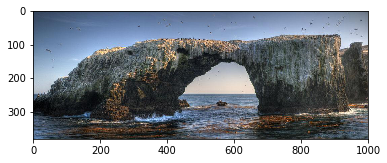

In [22]:
# load the test image
#img_url = 'http://places2.csail.mit.edu/imgs/12.jpg'
#os.system('wget %s -q -O test.jpg' % img_url)
img = Image.open('test.jpg')
tf_img = tf(img)
input_img = V(tf_img.unsqueeze(0))

tf_img = np.rollaxis(tf_img.numpy(),0,3)

plt.imshow(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


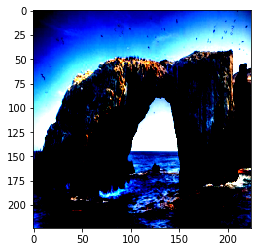

In [23]:
plt.imshow(tf_img)


In [24]:
# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [25]:
# output the prediction of scene category
classes = ['indoor', 'nature', 'outdoor']
print('--SCENE CATEGORIES:')
for i in range(0, 3):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

--SCENE CATEGORIES:
0.850 -> nature
0.093 -> outdoor
0.057 -> indoor


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


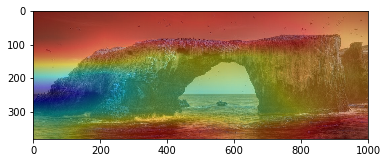

In [31]:
# generate class activation mapping
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[1]])

img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5

plt.imshow(result.astype(int))


In [29]:
CAMs[0].shape

(256, 256)

[512, 7, 7]
[(1, 512), (1, 49)]
(7, 7)


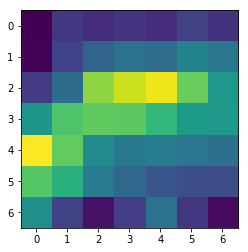

In [30]:
feature_conv = features_blobs[0]
class_idx = [idx[0]]

nc, h, w = feature_conv.shape
print([nc, h, w])
cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
# 14 x 14 = 196
print([weight_softmax[class_idx].shape, cam.shape])
cam = cam.reshape(h, w)
print(cam.shape)
# scalining
cam = cam - np.min(cam)
cam_img = cam / np.max(cam)

plt.imshow(cam_img)



In [ ]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(imresize(cam_img, size_upsample))
    return output_cam